# Ejemplo práctico de un modelo supervisado de clasificación
---

Autor: Manuel Díaz Bendito

---

El objetivo de este notebook, dado el dataset del [Census Income (Adult)](https://archive.ics.uci.edu/dataset/2/adult), desarrollar un modelo predictivo para determinar si el ingreso de un individuo excede los $50,000 al año, basándose en características demográficas y laborales.

El desarrollo del notebook se compone de 4 pasos fundamentales:

* La carga, preparación y realización del Exploratory Data Analysis (EDA) de los datos.
* El procesado e ingeniería de características de estos datos.
* La elección, entrenamiento, prueba y evaluación de un modelo de Machine Learning capaz de satisfacer las necesidades del problema.
* La validación de los resultados obtenidos, y la conclusión final del desarrollo.

---

# 0 - Instalaciones necesarias e importación de librerías utilizadas

## Instalación de librerías
---
Además de la librería propia del dataset objeto de estudio, se ha instalado la librería de [XGBoost](https://xgboost.readthedocs.io/en/stable/index.html), al ser el modelo que se ha utilizado para el desarrollo (la elección de este modelo se desarrollará más adelante en este notebook), y la librería scikit-plot, utilizada para la evaluación del modelo.

Si durante la fase de importación, el usuario se encuentra con algún error de importación, deberá añadir la instalación de dicha librería en este bloque.

---

In [1]:
!pip install ucimlrepo

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\balle\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\balle\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


---
Si tienes un macbook con chip sillicon, deberás ejectuar el sigueinte comando en el Terminal:

```bash
brew install libomp
```
---

In [3]:
!pip install scikit-plot

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\balle\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Importación de librerías

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import random

from ucimlrepo import fetch_ucirepo

In [2]:
pd.options.display.max_columns = 100

# 1 - Carga, preparación y EDA de los datos

## 1.1 - Carga del dataset
---
La carga del dataset se realiza utilizando la librería desarrolada por la Universidad Pública de Irvine.

---

In [7]:
# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
df_train_raw = adult.data.features
df_target_raw = adult.data.targets

In [8]:
df_train_raw.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [9]:
df_target_raw.head()

,income
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K


In [10]:
df_train_raw.shape

(48842, 14)

## 1.2 - Preparación del dataset
---
En este punto, se unen datos y las etiquetas (descargados por separado en la carga del dataset), y se mapea el target de la variable categórica que es originalmente, a una variable binaria (0/1). Para ello, se asigna a los sueldos inferiores a $50000 con la etiqueta 0, y a los superiores, con la etiqueta 1.

---

In [11]:
# Imprimimos por pantalla cómo es la variable objetivo inicialmente.
df_target_raw.value_counts()

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

In [12]:
# Construimos un diccionario con el mapeo a realizar.
target_mapper = {'<=50K': 0, '<=50K.': 0, '>50K': 1, '>50K.': 1}

In [15]:
# Unimos datos y  en el mismo dataframe y aplicamos el mapeo de la variable objetivo.
df_train_raw['target'] = df_target_raw['income'].map(target_mapper)

In [16]:
# Imprimimos por pantalla el nuevo target y su presencia (tanto por 1) en el dataset.
df_train_raw['target'].value_counts()

target
0    37155
1    11687
Name: count, dtype: int64

---
Un primer vistazo a las clases del dataset muestra que es un dataset **claramente desbalanceado**, es decir, con una clase (en este caso, la clase 0) mucho más presente que la otra.
Esto será un punto importante a abordar, dado que métricas tradicionales como son el accuracy del modelo no tendrán tanto peso en el momento de la evaluación, y habrá que prestar atención a otras métricas disponibles para evaluar la capacidad predictiva del modelo, como son la "precision", el "recall" o el área bajo la curva ROC.

---

## 1.3 - EDA
---
En este punto, se realiza el EDA del dataset propuesto. En este desarrollo, se ha dividido el EDA en tres puntos:
* Una exploración preliminar de las variables numéricas.
* Una exploración gráfica y tabular de las variables categóricas.
* Una exploración gráfica de las variables numéricas.

Como punto previo a todo el análisis, las variables sobre las que realizar el EDA son las siguientes (las definiciones son aproximaciones en cuanto al contexto y la documentación disponible):
* age: la edad del usuario - **numérica**
* workclass: sector en el qeu trabaja el usuario - **categórica**
* fnlwgt: "final weight" - en esencia, tras una búsqueda superficial, es el número de población que el censo cree que representa al usuario - **numérica**
* education: el nivel de educación del usuario - **categórica**
* education-num: análogo, es el nivel de educación del usuario - **numérica**
* marital-status: estado civil del usuario - **categórica**
* occupation: trabajo del usuario - **categórica**
* relationship: estado civil del usario respecto a otros - **categórica**
* race: raza del usuario - **categórica**
* sex: género del usuario - **categórica**
* capital-gain: ganancias económicas del usuario paralelas al salario - **numérica**
* capital-loss: pérdidas económicas del usuario paralelas al salario - **numérica**
* hours-per-week: horas trabajadas a la semana por el usuario - **numérica**
* native-country: país de origen del usuario - **categórica**

---

### 1.3.1 - Exploración preliminar de las variables numéricas
---
En este punto nos valemos del método describe para ver las métricas más inmediatas de las variables numérias.
Asimismo, obtenemos la matriz de correlación entre ellas.

---

In [17]:
df_train_raw.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,target
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382,0.239282
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444,0.426649
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [18]:
df_train_raw.corr(numeric_only = True)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,target
age,1.000000,-0.076628,0.030940,0.077229,0.056944,0.071558,0.230369
fnlwgt,-0.076628,1.000000,-0.038761,-0.003706,-0.004366,-0.013519,-0.006339
education-num,0.030940,-0.038761,1.000000,0.125146,0.080972,0.143689,0.332613
capital-gain,0.077229,-0.003706,0.125146,1.000000,-0.031441,0.082157,0.223013
capital-loss,0.056944,-0.004366,0.080972,-0.031441,1.000000,0.054467,0.147554
hours-per-week,0.071558,-0.013519,0.143689,0.082157,0.054467,1.000000,0.227687
target,0.230369,-0.006339,0.332613,0.223013,0.147554,0.227687,1.000000


---
La primera lectura de este análisis preliminar nos muestra que, en principio, no hay ninguna variable numérica con valores extraños teniendo en cuenta la información que representa. No hay valores negativos, ni disonantes en ninguno de los campos.
Cabe resaltar, por ejemplo, que el "capital-gain" tiene el valor máximo de 99999, que parece representar un valor de saturación. Todos aquellos usuarios que tengan un "capital-gain" superior, tendrán asignado dicho valor por defecto.
Asimismo, el valor de saturación de "hours-per-week" es 99 horas.

Respecto a la correlación, el target parece guardar especial correlación numérica con "education-num", lo cual tendría sentido, dado que *en general*, un mayor nivel de educación se traduce en un mayor nivel de ingresos. Correlaciones también algo más grandes ocurren con "age", "capital-gain" y "hours-per-week". Esto también va en concordancia con lo anteirormente descrito, dado que una mayor edad, unos ingresos altos de otras fuentes o un mayor número de horas trabajadas a la semana se traduce, *en general*, en mayores ingresos.

---

### 1.3.2 - Exploración gráfica y tabulada de las variables categóricas
---
Para este punto, y por comodidad, se ha desarrollado la función **plot_cat_feat**. Esta función grafica, para cada categoría presente en la variable a analizar, el porcentaje de clase 0 y de clase 1 acumulados en un diagrama de barras. Además, superupesto al diagrama de barras, se grafica en un diagrama de líneas el porcentaje de cada categoría sobre el total.

A parte, si se desea, se puede mostrar la gráfica en formato tabular, en caso de ser necesario un análisis más preciso de los resultados.

El código de la función está comentado para su comprensión.

---

In [24]:
def plot_cat_feat(df, feature, print_detail = False):
  '''
  Función encargada de mostrar un gráfico con el % de clases de cada categoría y
  su presencia total en el dataset, para una variable o característica dada.

  Parámetros de entrada:
    - df: dataframe en el que se encuentran los datos a analizar.
    - feature: nombre de la característica a analizar.
    - print_detail: bandera que activa o desactiva la información tabulada del
    gráfico

  La función no tiene parámetros de retorno.
  '''

  # Obtenemos la agrupación de la característica por categorías, y calculamos la
  # media y la cuenta de la variable objetivo, para cada categoría.
  df_grouped = df[[feature,'target']].groupby([feature]).agg(['mean','count'])['target']
  df_grouped = df_grouped.sort_values('mean')

  # Obtenemos para dicho dataframe variables auxiliares utilizadas en el gráfico
  df_grouped['% clase 1'] = df_grouped['mean'] * 100
  df_grouped['% clase 0'] = (1 - df_grouped['mean']) * 100
  df_grouped['% presencia'] = df_grouped['count'] / df_grouped['count'].sum() * 100

  # Graficamos el diagrama de barras del % de clases de cada categoría.
  ax = df_grouped[['% clase 1','% clase 0']].plot(kind = 'bar',
                                                stacked = True,
                                                figsize = (7,7),
                                                title = '% de clase 0 y 1 en cada categoría de la característica ' + feature,
                                                color = ['cornflowerblue','tan'])

  # Graficamos el diagrama de líneas el % de presencia de cada categoría.
  df_grouped['% presencia'].plot(kind = 'line', color = 'red', linewidth= 1.5, linestyle = '-.', rot=90)

  ax.set_xlabel('Categorías de la característica ' + feature, )
  ax.set_ylabel('%')
  plt.legend(['% presencia','% clase 1','% clase 0'])

  plt.show()

  # Mostramos por pantalla la infomración de la gráfica, tabulada
  if print_detail:
    print("\n\n------------------------\n\n")
    display(df_grouped[['% clase 1','% clase 0','% presencia']])

#### workclass
---
La variable **workclass** tiene como mayoría la categoría "private", que hace referencia al sector privado. Este sector tiene el % de clase 1 medio del dataset. Es por lo anterior por lo que interesan los extremos:
* En primer lugar, la categoría "Never-worked" no tiene ningún usuario con clase 1, lo cual tiene sentido. Sin embargo, la muestra es tan pequeña (menos del 0.02%), que podría interpretarse como ruido.
* Por otro lado, la categoría "Without-pay" tiene presencia de clase 1, lo cual no parece ser congruente con la categoría. Por ello, se considera un error.
* Asimismo, encontramos coherencia con que los usuarios empresarios tengan mayor nivel de ingresos que en el sector privado.
* Por último, resaltar la presencia de usuarios con "workclass" desconocida (?).

Como conclusión, podemos ver una clara diferienciación entre las categorías y su porcentaje de clase positiva. Sin embargo, las clases minoritarias podrían aportar ruido al modelo, y por lo tanto, serán agrupadas e imputadas como nulas (*la imputación como nulo es una decisión que se ha tomado a posteriori tras la realización de pruebas en el entrenamiento del modelo - en un primer lugar, se agruparon y mantuvieron como categoría independiente*).

Finalmente, aunque es cierto que podría parecer intuitivo agrupar las categorías que guardan el mismo signficado (trabajadores del gobierno, emprendedores...), su agrupación y posterior graficado diluye enormemente la diferencia sustancial entre categorías presente antes de la agruapción. Es por ello que se concluye que esta agrupación no sería beneficiosa para el modelo final entrenado.

---

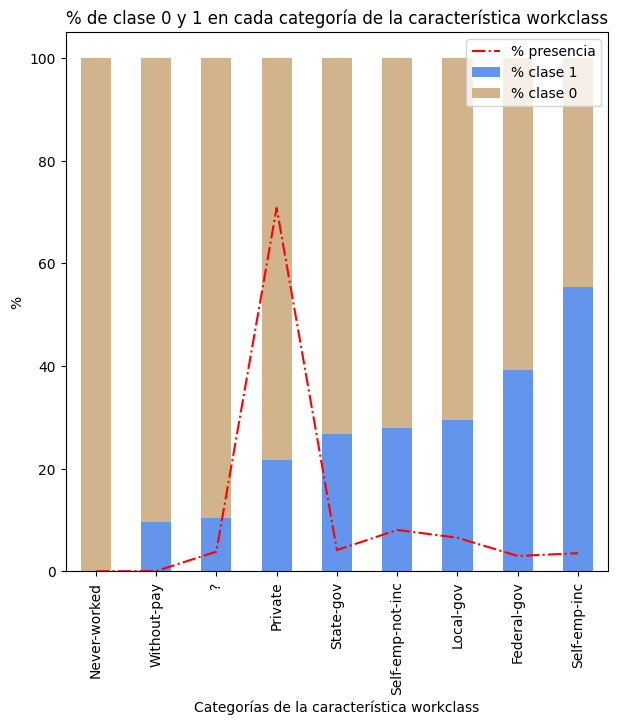

In [25]:
plot_cat_feat(df_train_raw, 'workclass')

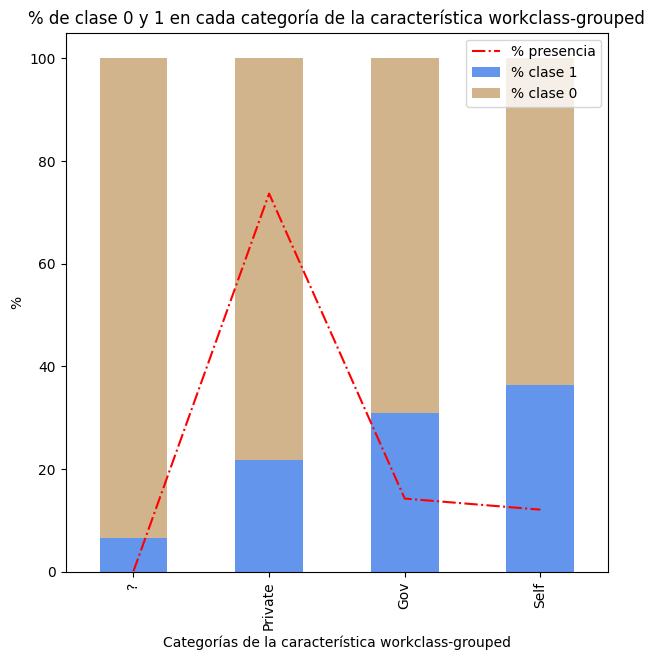

In [26]:
# Mapeamos la característica workclass por grupos.
workclass_map = {'Never-worked': '?',
                 'Without-pay': '?',
                 'Private': 'Private',
                 'State-gov': 'Gov',
                 'Local-gov': 'Gov',
                 'Federal-gov': 'Gov',
                 'Self-emp-not-inc': 'Self',
                 'Self-emp-inc': 'Self'}
df_train_raw['workclass-grouped'] = df_train_raw['workclass'].map(workclass_map)

plot_cat_feat(df_train_raw, 'workclass-grouped')

#### education
---
La variable **education** tiene como mayoría la categoría "HS-graduate", que hace referencia a los graduados del insituto. Este sector tiene el % de clase 1 inferior al medio del dataset. Otras lecturas de esta gráfica son:
* Podemos ver que los usuarios con estudios, y especialmente con estudios superiores, son los que presentan un mayor nivel de ingreso. Esto tiene sentido con lo tratado anteriormente en el punto de las variables numéricas, en concreto, la variable "education-num".
* Además, todos los usuarios con niveles de educación inferiores al insituto, presentan un nivel de ingresos inferior, aunque no hay grandes discrepancias dentro de este grupo.
* En general, se pueden ver tres grandes grupos para esta categoría: aquellos usuarios que no terminaron los estudios del instituto, los que los terminaron o hicieron un curso superior y, finalmente, los ususarios que tienen estudios superiores.
* Los grupos anteriores tienen claras diferencias de clase 1 entre sí, pero no internamente.
* No obstante, no parece conveniente agruparlos como se ha comentado por la posible pérdida de información agregada en dicha agrupación.

Como conclusión, podemos ver una clara diferienciación entre las categorías y su porcentaje de clase positiva. Sin embargo, las clases minoritarias podrían aportar ruido al modelo, y por lo tanto, serán agrupadas e imputadas como nulas (*la imputación como nulo es una decisión que se ha tomado a posteriori tras la realización de pruebas en el entrenamiento del modelo - en un primer lugar, se agruparon y mantuvieron como categoría independiente*).

---

In [ ]:
plot_cat_feat(df_train_raw, 'education')

#### marital-status
---
La variable **marital-status** tiene como mayoría la categoría "Married-civ-spouse", que hace referencia a los usuarios casados por lo civil. Este sector tiene el % de clase 1 muy superior al medio del dataset, lo cual es un buen indicador de que esta característica ayudará en la predicción. Además:
* Podemos ver que un gran porcentaje (más del 80%) de los usuarios están comprendidos en "Married-civ-spouse" y "Never-married", categorías excluyentes.
* Además, tienen porcentajes de clase 1 muy dispares (el primero tiene el más alto, y el segundo, el más bajo), por lo que esta clase ayudará enormemente en la clasificación.
* La categoría "Married-AF-spouse", si bien tiene un alto porcentaje de clase 1, está muy poco presente en el dataset (menos del 1%), por lo que será imputada como valor nulo para no añadir ruido al dataset.

Como conclusión, podemos ver una clara diferienciación entre dos de las categorías mayoritarias, por lo que esta característica será de gran utilidad para el modelado. Sin embargo, la clase minoritaria podría aportar ruido al modelo, por lo que será imputada como nulo (*la imputación como nulo es una decisión que se ha tomado a posteriori tras la realización de pruebas en el entrenamiento del modelo - en un primer lugar, se agruparon y mantuvieron como categoría independiente*).

---

In [ ]:
plot_cat_feat(df_train_raw, 'marital-status')

#### occupation
---
La variable **occupation** tiene varias categorías mayoritarias con porcentajes de clase 1 en un gran abanico. Además:
* Destacamos que los puestos de dirección y de profesorado son los que tienen el mayor porcentaje de clase 1.
* Asimismo, el porcentaje de clase 1 del servicio doméstico es prácticamente nulo.
* Finalmente, la clara diferenciación entre clases indica que su agrupación sería contraproducente, y la agrupación de las clases minoritarias para elimiar el ruido vuelve a resultar una solución lógica.

Como conclusión, podemos ver una clara diferienciación entre las categorías y su porcentaje de clase positiva. Sin embargo, las clases minoritarias podrían aportar ruido al modelo, y por lo tanto, serán agrupadas e imputadas como nulas (*la imputación como nulo es una decisión que se ha tomado a posteriori tras la realización de pruebas en el entrenamiento del modelo - en un primer lugar, se agruparon y mantuvieron como categoría independiente*).

---

In [ ]:
plot_cat_feat(df_train_raw, 'occupation')

#### relationship
---
La variable **relationship** tiene dos grupos de categorías con un porcentaje de clase 1 similar; "Husband" y "Wife" por un lado, y el resto por el otro. Con lo anterior:
* Es destacable la gran diferencia entre estos dos grupos, y la importancia que tendrá a la hora de discernir entre aquellos usuarios con mayor salario.
* Además, el porcentaje de ambos grupos es aproximadamente el 50%, lo cual permite con mayor facilidad una separación eficiente.

Como conclusión, podemos ver una clara diferienciación entre las categorías y su porcentaje de clase positiva. Esta característica se plantea como altamente informativa en el EDA.

---

In [ ]:
plot_cat_feat(df_train_raw, 'relationship')

#### race
---
La variable **race** tiene como mayorá la categoría "White", con un porcentaje de clase 1 alineado con la media del dataset. Además:
* No existe un gran salto del porcentaje la clase 1 entre categorías, de modo que es poco probable que la categoría race, de forma independiente, sea útil para la clasificación del usuario.
* Asimismo, la baja cantidad de razas distintas de "White" o "Black" podrían ser ruido para el modelo, por lo que serán agrupadas.

Como conclusión, no podemos ver una clara diferienciación entre las categorías y su porcentaje de clase positiva. Además, las clases minoritarias podrían aportar ruido al modelo, y por lo tanto, serán agrupadas e imputadas como nulas (*la imputación como nulo es una decisión que se ha tomado a posteriori tras la realización de pruebas en el entrenamiento del modelo - en un primer lugar, se agruparon y mantuvieron como categoría independiente*).

---

In [ ]:
plot_cat_feat(df_train_raw, 'race')

#### sex
---
La variable **sex** es una característica que solo tiene dos categorías y, por sencillez, debería tratarse como una variable binaria (0/1). La lectura principal del análisis es que los varones, categoría mayoritaria, presentan un porcentaje de clase 1 algo superior a la media, y las mujeres, categoría minoritaria, presenta un porcentaje de clase 1 algo inferior, lo cual a priori podría indicar que es una variable que será importante para la clasificación. Sin embargo, la presencia de otras variables que tienen esta información de forma más granular, es muy probable que ensombrezcan esta variable, haciendo que su uso sea de menor importancia.

---

In [ ]:
plot_cat_feat(df_train_raw, 'sex')

#### native-country
---
La variable **native-country** tiene como categoría mayoritaria la categoría "United-States", presentando más del 90% del conjunto de categorías, con un porcentaje de clase 1 medio con respecto al del dataset. Con todo lo anterior:
* La categoría mayoritaria eclipsa el resto de categorías, que pueden ser ruido o aportar poca información al modelo.
* No parece relevante la agrupación de estas categorías minoritarias, por no perder la diferencia de la presencia de la clase 1 a lo largo de estas.
* Las clases minoritarias, mucho más presentes que en otras variables, serán agrupadas para evitar el aporte de ruido al modelo.

Como conclusión, podemos ver una clara diferienciación entre la presencia de la categoría mayoritaria y el resto de categorías. Además, las categorías minoritarias podrían aportar ruido al modelo, y por lo tanto, serán agrupadas e imputadas como nulas (*la imputación como nulo es una decisión que se ha tomado a posteriori tras la realización de pruebas en el entrenamiento del modelo - en un primer lugar, se agruparon y mantuvieron como categoría independiente*).

---

In [ ]:
plot_cat_feat(df_train_raw, 'native-country')

### 1.3.3 - Exploración gráfica de las variables numéricas
---
Para este punto, y por comodidad, se ha desarrollado la función **plot_num_feat**. Esta función grafica, para las agrupaciones de la característica numérica elegidas por el usuario, el porcentaje de clase 0 y de clase 1 acumulados en un diagrama de barras. Además, superupesto al diagrama de barras, se grafica en un diagrama de líneas el porcentaje de cada categoría sobre el total. Asimismo, si el lector lo desea, se puede mostrar por pantalla un box plot de la característica para ayudar en el análisis.

El código de la función está comentado para su comprensión.

---

In [ ]:
def plot_num_feat(df, feat, bins, print_box = False):
  '''
  Función encargada de mostrar un gráfico con, dado bien un número de
  particiones o los puntos de corte de una variable numérica, el % de clases
  de cada agrupación y su presencia total en el dataset.

  Parámetros de entrada:
    - df: dataframe en el que se encuentran los datos a analizar.
    - feature: nombre de la característica a analizar.
    - bins: valor numérico con el número de particiones o lista con los puntos
    de corte deseados para la variable numérica.
    - print_box: bandera que, si se activa, muestra un diagrama de caja de la
    característica numérica analizada.

  La función no tiene parámetros de retorno.
  '''

  # Creamos un nuevo dataframe con las particiones requeridas por el usuario
  df_binned = df[[feat,'target']].copy()
  df_binned['bins'] = pd.cut(df[feat], bins = bins)

  # Calculamos la media y cuenta de la variable objetivo para las agrupaciones y
  # creamos una serie de parámetros auxiliares para la graficación
  df_grouped = df_binned[['bins','target']].groupby(['bins']).agg(['mean','count'])['target']
  df_grouped['% clase 1'] = df_grouped['mean'] * 100
  df_grouped['% clase 0'] = (1 - df_grouped['mean']) * 100
  df_grouped['% presencia'] = df_grouped['count'] / df_grouped['count'].sum() * 100

  # Graficamos el diagrama de barras del % de clases de cada agrupación.
  ax = df_grouped[['% clase 1','% clase 0']].plot(kind = 'bar',
                                                stacked = True,
                                                figsize = (7,7),
                                                title = '% de clase 0 y 1 en cada grupo de la característica ' + feat,
                                                color = ['cornflowerblue','tan'])

  # Graficamos el diagrama de líneaw del % de presencia de cada agrupación.
  df_grouped['% presencia'].plot(kind = 'line', color = 'red', linewidth= 1.5, linestyle = '-.', rot=90)

  ax.set_xlabel('Grupos de la característica ' + feat)
  ax.set_ylabel('%')
  plt.legend(['% presencia','% clase 1','% clase 0'])

  plt.show()

  # Si el usuario lo desea, mostramos un diagrama de caja de la característica.
  if print_box:
    df[feat].plot(kind = 'box')

#### age
---
La variable **age** guarda una relación de campana de Gauss desplazada para los saltos de 10 en 10 años elegidos y el número de usuarios presentes en cada grupo. Si bien es cierto que encontramos a los usuarios de entre 20 y 40 años como la mayoría, son los usuarios de entre 40 y 50 los que tienen un mayor % de clase 1.

Además, es importante señalar (y queda reforzado si se analiza el diagrama de caja), que los usuarios de más de 70 años son outliers de la característica.

Como conclusión, esta característica se presenta como altamente informativa, y la agrupación realizada es sensible al desplazamiento de la campana de los grupos de edad entre 20 y 40 y los de 40 y 50, de modo que también será de utilidad en la fase de modelado.

---

In [ ]:
plot_num_feat(df_train_raw, 'age', [10,20,30,40,50,60,70,80,90])

#### fnlwgt
---
La variable **fnlwgt** presenta un % de clase 1 relativamente estable para todas las agrupaciones realizadas. Sin embargo, el diagrama de caja muestra la presencia de un gran número de valores atípicos u outliers, que se alejan enormemente de los valores típicos de la variable. Por todo lo anterior, se decide normalizar la variable, y mantener las agrupaciones realizadas, dado que se han encontrado agrupaciones de datos con un % de clase 1 prácticamente nula.

Como conclusión, se decide normalizar la variable por un lado, y calcular una nueva característica que recoja la información que se puede ver en las agrupaciones realizadas.

---

In [ ]:
plot_num_feat(df_train_raw, 'fnlwgt', 10)

#### education-num
---
La variable **education-num** es análoga a la variable **education**, y el análisis realizado se puede aplicar de igual forma para esta variable.

---

In [ ]:
plot_num_feat(df_train_raw, 'education-num', np.linspace(0,16,17))

#### capital-gain
---
La variable **capital-gain** tiene, como punto más destacable, un inmenso número de ceros. Tanto es así, que más del 90% de los valores de esta variable son cero a lo largo de todo el dataset, y el diagrama de caja muestra que todos los valores distintos de cero son atípicos. Es por lo anterior por lo que se normalizará la variable. Asimismo, de cara a utilizar los outliers de la mejor manera posible, se plantea la posibilidad de agruparlos y de imputar los ceros como nulos.

Como conclusión, se plantea normalizar la variable y, en paralelo, agruparla en distintos conjuntos de outliers, imputando el valor 0 como nulo.

---

In [ ]:
plot_num_feat(df_train_raw, 'capital-gain', [-0.1,0,5000,10000,50000,99999])

#### capital-loss
---
La variable **capital-loss** tiene, como punto más destacable, un inmenso número de ceros. Tanto es así, que más del 95% de los valores de esta variable son cero a lo largo de todo el dataset, y el diagrama de caja muestra que todos los valores distintos de cero son atípicos. Es por lo anterior por lo que se normalizará la variable. Asimismo, de cara a utilizar los outliers de la mejor manera posible, se plantea la posibilidad de agruparlos y de imputar los ceros como nulos.

Como conclusión, se plantea normalizar la variable y, en paralelo, agruparla en distintos conjuntos de outliers, imputando el valor 0 como nulo.

---

In [ ]:
plot_num_feat(df_train_raw, 'capital-loss', [-0.1,0,500,1000,1500,2000,3000,4000,4500])

#### hours-per-week
---
La variable **hours-per-week**, como es lógico, presenta un gran número de usuarios dentro del rango habitual de una jornada laboral (30-40 horas), y valores notablemente atípicos (como puede verse en el diagrama de caja), tanto para usuarios con jornadas semanales de menos de 30 como de más de 40. Además, como ya se comentó anteriormente, el número de horas trabajadas a la semana guarda una clara relación lienal con el ingreso medio de los usuarios, si bien es cierto que tiene un punto de saturación a partir de las 60 horas, después del que el % de clase 1 deja de ser superior.

Concluimos que mantendremos esta clase tal y como está, y además se le dará al modelo en formato agrupado, para tratar de hacerle saber la curva de saturación explicada.

---

In [ ]:
plot_num_feat(df_train_raw, 'hours-per-week', [0,20,40,60,99])

# 2 - Procesado e ingeniería de características
---
En este punto, se realiza el procesado previo a la ingeniería de características, y la ingeniería de características propiamente dicha. Esta ingeniería de características se ha realizado utilizando la información y los insights obtenidos del EDA, y se han tomado las siguientes decisiones:

* Para el procesamiento, se han imputado como nulos todas las categorías desconocidas (de categoría "?").
* Asimismo, en el procesado de las variables, existe un procesado previo a la ingeniería de características que consiste, si lo desea el usuario, en agrupar las categorías minoritarias e imputarlas como nulo.
* Para las características categóricas, existen pocos modelos que las acepten tal cual están definidas, y su tratamiento internamente no suele dar mejores resultados que un pretratamiento por parte del Data Scienist. Por lo tanto, se ha decidido hacer transformaciones de categórico a numérico. En ese caso, se presentan dos alternativas:
  * One-hot-encoding: que consiste en, dada una característica categórica, construir tantas nuevas características binarias como categorías tenga la característica original, siendo todas cero salvo la que hace referencia a la categoría presente para el usuario. Este método, muy utilizado, tiene dos contrapartidas muy notables: el primer lugar, multiplica notablemente el número de columnas del dataset, haciendo más complejo el entrenamiento. Además, en la casuística de realizar una selección de características, la eliminación de una de las columnas derivadas podría hacer perder cohesión al dataset, y de cara a la explicabilidad, dificulta el proceso de evaluación del modelo.
  * Target encoding: que consiste en, para cada categoría presente en una característica, calcular el valor medio de porcentaje de la clase 1, y sustituir el valor categórico con dicho valor medio, numérico. Si bien es cierto que este proceso puede llevar al overfitting, si se hace bien puede sustituir al one-hot-encoding, reducir el tamaño del dataset de entrenamiento, y permitir una mayor explicabilidad. ** Por todo lo anterior, se ha decidido optar por este procesado de las características categóricas.**
* Para las características numéricas, existen tres opciones disponibles para su tratamiento:
  * Se puede dejar tal y como esta (será nuestro caso para variables como "age", "education-num" o "hours-per-week").
  * Se puede normalizar (será el caso de variables como "capital-gain" o "capital-loss").
  * Se puede hacer un procesamiento posterior. En este caso, se ha decidido realizar una agrupación numérica que refleja valor informativo, y posteriormente se ha realizado un target encoding a dichas agrupaciones para el entrenamiento del modelo.

Para este proceso, se han desarrollado tres funciones, que son llamadas iterativamente siguiendo las directrices de un diccionario con las transformaciones a realizar. Las funciones desarrolladas son **target_encoding_calculator**, **target_encoding_num_groups** y **mean_norm_calculation**.

Una descripción más detallada de cada función se puede encontrar en su definición.

---

In [ ]:
def target_encoding_calcuator(df, feat, target, threshold=0):
  '''
  Esta función se encarga de calcular el target encoding de una variable
  categórica dada.

  Parámetros de entrada:
    - df: dataframe en el que se encuentran los datos a analizar.
    - feat: nombre de la característica a procesar.
    - target: nombre de la variable objetivo
    - threshold: número mínimo de ocurrencias de una categoría para que no sea
    agrupada e imputada como nulo

  Parámetros de salida:
    - df: dataframe con la nueva variable procesada.

  '''

  print('Procesando la variable ' + feat)

  # En primer lugar, imputamos como nulas todas las categorías con presencia
  # inferior al threshold.
  if threshold > 0:
      df.loc[df[feat].isin(df[feat].value_counts().index[(df[feat].value_counts() < threshold)]),feat] = np.nan

  # Calculamos un diccionario con el mapeo de cada categoría con su % de clase 1
  unique_feat = df[feat].value_counts().index.to_list()
  feat_target = [df.loc[df[feat] == i, target].mean() for i in unique_feat]
  Map_feat_target = dict(zip(unique_feat, feat_target))

  # Definimos la nueva característica con el sufijo TE (Target Encoding)
  df[feat + '_TE'] = df[feat].map(Map_feat_target).astype(float)

  print('La variable ' + feat + ' de ha procesado correctamente')

  # Retornamos el dataframe con la variable procesada.
  return df

In [ ]:
def target_encoding_num_groups(df, feat, target, bins, threshold = 0):
  '''
  Esta función se encarga de calcular el target encoding de una agrupación dada
  de una variable numérica.

  Parámetros de entrada:
    - df: dataframe en el que se encuentran los datos a analizar.
    - feat: nombre de la característica a procesar.
    - target: nombre de la variable objetivo.
    - bins: valor numérico con el número de particiones o lista con los puntos
    de corte deseados para la variable numérica.
    - threshold: número mínimo de ocurrencias de una categoría para que no sea
    agrupada e imputada como nulo

  Parámetros de salida:
    - df: dataframe con la nueva variable procesada.

  '''

  # Creamos una nueva variabel categórica con las agrupaciones decididas.
  df[feat + '_bins'] = pd.cut(df[feat], bins = bins)

  # Calculamos el target encoding de esta nueva variable categórica.
  df = target_encoding_calcuator(df, feat + '_bins', target, threshold)
  df[feat + '_bins_TE'] = df[feat + '_bins_TE'].astype(float)

  # Retornamos el dataframe con la variable procesada.
  return df

In [ ]:
def mean_norm_calculation(df, feat):
  '''
  Esta función se encarga de calcular la normalización de una variable numérica

  Parámetros de entrada:
    - df: dataframe en el que se encuentran los datos a analizar.
    - feat: nombre de la característica a procesar.

  Parámetros de salida:
  - df: dataframe con la nueva variable procesada.

  '''

  return (df[feat]-df[feat].mean())/df[feat].std()

In [ ]:
# Copiamos el dataset original para no realizar transformaciones sobre este.
df_train = df_train_raw.copy()

## 2.1 - Procesado de los datos
---
En este paso, tomamos las características con valores desconocidos, y los imputamos como nulos (nans).

---

In [ ]:
miss_val_feats = ['workclass', 'occupation', 'native-country']

for i in miss_val_feats:
  df_train.loc[df_train[i] == '?', i] = np.nan

## 2.2 - Ingeniería de características
---
En este paso, se realiza la ingeniería de características de todas las variables. Para ello, valiéndonos de las funciones, se definen tres diccionarios con la información de las transformaciones a realizar.

---

In [ ]:
# Diccionario con información de las transformaciones a realizar para las
# variables categóricas.
cat_feats2TE = {
    'workclass': 100,
    'education': 100,
    'marital-status': 100,
    'occupation': 100,
    'relationship': 0,
    'race': 0,
    'native-country': 50
}

# Diccionario con información de las transformaciones a realizar para las
# variables numéricas (target encoding)
num_feats2TE = {
    "age": [10,20,30,40,50,60,70,80,90],
    "fnlwgt": 10,
    "education-num": np.linspace(0,16,17),
    "capital-gain": [0,5000,10000,50000,99999],
    "capital-loss": [0,500,1000,1500,2000,3000,4000,4500],
    "hours-per-week": [0,20,40,60,99]
}

# Lista con las características numéricas a normalizar
feats2norm = ["fnlwgt",
              "capital-gain",
              "capital-loss"]

### 2.2.1 - Ingeniería de características categóricas
---
Para cada característica categórica (salvo "sex"), se tiene un valor mínimo de presencia de cada categoría para no agruparlas como nulo. Este valor se ha tomado en base al EDA realizado, y a iteraciones de entrenamientos durante el desarrollo de este proyecto.

---

In [ ]:
# Para la variable sex, un simple mapeo de categórico a binario es suficiente.
bin_sex_map = {'Male': 0, 'Female': 1}

df_train['bin_sex'] = df_train['sex'].map(bin_sex_map)

In [ ]:
for k, v in cat_feats2TE.items():
  df_train = target_encoding_calcuator(df_train, k, 'target', v)

### 2.2.2 - Ingeniería de características numéricas
---
Para cada característica numérica, se realizan las tres transformaciones descritas, según el caso. Las decisiones tomadas para estas transformaciones se basan en el EDA realizado, y las iteraciones de entrenamientos durante el desarrollo de este proyecto

---

In [ ]:
for k, v in num_feats2TE.items():
  df_train = target_encoding_num_groups(df_train, k, 'target', v)

In [ ]:
for i in feats2norm:
  df_train[i + '_mean_norm'] = mean_norm_calculation(df_train, i)

# 3 - Modelado
---
Una vez construido el dataset, se procede al entrenamiento de un modelo de Machine Learning.

Con todo lo aprendido anteriormente de los datos, tratándose de un **problema de clasificación binaria**, con un dataset **desbalanceado**, un pequeño grupo de características a utilizar y claras agrupaciones que pueden ayudar en la decisión de la clase final, se ha decidido optar por un **XGBoost** como modelo para este proyecto.

La decisión se ha tomado por la demostrada eficiencia de estos modelos en los problemas de clasificación binaria, en el tratamiento de datasets desbalanceados y en la capacidad de tratamiento de datos nulos como información desconocida.

---

In [ ]:
# Declaramos las características a utilizar en el entrenamiento del modelo, así
# como el target del mismo.
feats2use = [
 'age',
 'education-num',
 'hours-per-week',
 'bin_sex',
 'workclass_TE',
 'education_TE',
 'marital-status_TE',
 'occupation_TE',
 'relationship_TE',
 'race_TE',
 'native-country_TE',
 'fnlwgt_mean_norm',
 'capital-gain_mean_norm',
 'capital-loss_mean_norm',
 'age_bins_TE',
 'fnlwgt_bins_TE',
 'education-num_bins_TE',
 'capital-gain_bins_TE',
 'capital-loss_bins_TE',
 'hours-per-week_bins_TE',
 'target'
]

In [ ]:
# Realizamos la selección de las características a utilizar del dataset
# procesado
df_FM_train = df_train[feats2use].copy()

## 3.1 - Definición de los datasets de entrenamiento y evaluación del modelo

In [ ]:
# Definimos las columans con las características, eliminando la columan target.
columns_x = df_FM_train.columns.drop('target')

In [ ]:
# Definimos las variables X e y, con los datos de entrenamiento y la variable
# objetivo, respectivamente.
X = df_FM_train[columns_x]
y = df_FM_train['target']

In [ ]:
# Dividimos el dataset en entrenamiento y evaluación (80% - 20% respectivamente)
X_train, X_test,  y_train, y_test= train_test_split(X, y,
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=0)

In [ ]:
# Para el xgboost, se declara una DMatrix con los datos de entrenamiento
xgtrain = xgb.DMatrix(X_train.values, y_train.values)

In [ ]:
# Para el xgboost, se declara una DMatrix con los datos de evaluación
xgtest = xgb.DMatrix(X_test.values, y_test.values)

## 3.2 - Entrenamiento del modelo
---
En este punto, se entrena el modelo. Nótese que los hiperparámetros elegidos
se han tomado tras varias iteraciones de un proceso de búsqueda de hiperparámetros reticular, descrito más adelante. Si bien es cierto que puede realizarse una búsqueda de mayor profundidad de cara a obtener mejores resultados, los resultados obtenidos han resultado ser satisfactorios para el marco de este proyecto.

En la [documentación oficial](https://xgboost.readthedocs.io/en/stable/parameter.html) de XGBoost se encuentra información detallada de los hiperparámetros utilizados.

---

In [ ]:
# Definimos los parámetros de entrada a la función de entrenamiento del modelo.
evallist = [(xgtrain, 'train'), (xgtest, 'eval')]

num_round = 1000

param = {
        'max_depth': 10,
        'eta': 0.01,
        'objective': 'binary:logistic',
        'max_delta_step': 1,
        'min_child_weight': 6,
        'gamma': 0.1,
        'nthread': 4,
        'eval_metric': 'auc'
        }

In [ ]:
# Entrenamos el modelo final.
xgb_model = xgb.train(
    params=param,
    dtrain=xgtrain,
    num_boost_round=num_round,
    evals=evallist
)

## 3.3 - Búsqueda reticular de hiperparámetros
---
En este punto, se ha desarrollado una función para la búsqueda reticular de hiperparámetros realizando un entrenamiento de validación cruzada.

Esta función, inspirada en la función de funcionamiento análogo de [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html), elige, dentro de un hiperespacio de hiperparámetros definido en un diccionario, un conjunto de dichos hiperparámetros de forma aleatoria, entrena un modelo validándolo de forma cruzada, y se queda, tras un número de iteraciones definidas por el usuario, con el conjunto de hiperparámetros que mejor resultados ha dado para la métrica a optimizar definida por el usuario.

Una descripción más detallada del funcionamiento de la función se puede ver en la definición de la misma.

---

In [ ]:
# Declaración del hiperespacio de hiperparámetros a utilizar en la búsqueda.
parameters_pre_FS = {
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'max_depth': [9, 12, 15],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1, 10],
    'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 10],
    'nthread': [4],
    'eval_metric': ['auc']
}

In [ ]:
def RandGridsearchCV(param, xgtrain, num_round = 1000, niter = 100, cross_val = 5, seed = 0):
  '''
  Esta función realiza una búsqueda aleatoria de hiperparámetros en un
  hiperespacio de hiperparámetros dado, y devuelve el conjunto de
  hiperparámetros que mejores resultados ha dado, utilizando un proceso de
  validación cruzada.

  Parámetros de entrada:
  - param: hiperespacio con los hiperparámetros en el que realizar la búsqueda.
  - xgtrain: dataset de entrenamiento.
  - num_round: número de árboles de cada iteración.
  - niter: número de iteraciones o conjuntos de hiperparámetros a probar.
  - cross_val: número de pliegues para el proceso de validación cruzada.
  - seed: semilla aleatoria del proceso de validación cruzada.

  Parámetros de salida:
  - selected_params: los mejores hiperparámetros obtenidos.


  '''
  max_auc = 0
  selected_params = None

  # Hacemos tantas selecciones aleatorias como decida el usuario.
  for i in range(niter):
    print("Prueba número: " + str(i))

    # Creamos un diccionario con el set de hiperparámetros a probar
    sub_params = {k: random.sample(v,1)[0] for k,v in param.items()}

    # Realizamos el entrenamiento con validación cruzada
    cv_model = xgb.cv(sub_params, xgtrain, num_round, cross_val, seed)

    # Obtenemos el mejor área bajo la curva AUC de esta iteración.
    best_auc = cv_model['test-auc-mean'].max()
    print("El mejor ROC AUC para esta iteración ha sido: " + str(best_auc))
    print("Los hiperparámetros utilizados han sido: " + str(sub_params))

    # Si el área bajo la curva AUC ha mejorado, lo guardamos como el mejor,
    # así como los hiperparámetros asociados.
    if best_auc > max_auc:
      max_auc = best_auc
      selected_params = sub_params

  # Retornamos los mejores hiperparámetrso obtenidos.
  print("El mejor ROC AUC Score obtenido es: " + str(max_auc))
  print("Los parámetros elegidos son " + str(selected_params))
  return selected_params

### 3.3.1 - Proceso iterativo de búsqueda
---
Este proceso iterativo ha sido utilizado para la elección del modelo. Queda a discreción del usuario repetirlo. Nótese que es un proceso largo. Si se quiere ver el funcionamiento de la función, se recomienda reducir el número de iteraciones.

---

In [ ]:
best_params = RandGridsearchCV(parameters_pre_FS, xgtrain, num_round = 1000, niter = 10, cross_val = 5, seed = 0)

### 3.3.2 - Impresión por pantalla de los mejores hiperparámetros encontrados

In [ ]:
best_params

# 4 - Evaluación del modelo obtenido
---
En este último punto, procedemos a evaluar el modelo entrenado. Para ello, como ya se ha comentado anteriormente, no nos valdremos únicamente del accuracy, al tratarse de un dataset desbalanceado. En contra, nos centraremos en métricas como la precisión, el recall y el área bajo la curva ROC.

Además, se representa la matriz de confusión para los datos de evaluación.

---

In [ ]:
# Obtenemos la predicción del modelo y el "ground truth"

y_pred_test = (xgb_model.predict(xgtest) > 0.5).astype(int)
y_pred_test_proba = xgb_model.predict(xgtest)
y_true_test = y_test

## 4.1 - Obtención de las métricas más relevantes del modelo

In [ ]:
cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print()

print("ACCURACY: " + str("{:.2f}".format(accuracy_score(y_true_test, y_pred_test) * 100)) + '%')
print("PRECISION: " + str("{:.2f}".format(precision_score(y_true_test, y_pred_test) * 100)) + '%')
print("RECALL: " + str("{:.2f}".format(recall_score(y_true_test, y_pred_test) * 100)) + '%')
print("ÁREA BAJO LA CURVA ROC AUC: " + str("{:.2f}".format(roc_auc_score(y_true_test, y_pred_test_proba))))

---
En resumen, obtenemos un modelo con una accuracy del 87%, un área bajo la curva ROC del 0.93, una precisión del 77% y un recall del 65%. Si bien es cierto que no son resultados extraordinarios, el modelo entrenado es un modelo robusto, sin overfitting, capaz de detectar un gran número de usuarios con clase 1 (elevada precision), aunque erra ocasionalmente, pasando por alto usuarios con clase 1 (no tan elevado recall).

Concluimos que el modelo entrenado tiene unos resultados satisfactorios.

---

## 4.2 - Obtención de la importancia de las características utilizadas en el modelo entrenado

---
De cara a un análisis posterior, se imprimen por pantalla las características con las que se ha entrenado el modelo, ordenadas de mayor a menor importancia para dicho intrenamiento.

---

In [ ]:
feat_importance = {int(k.replace('f','')): v for k, v in xgb_model.get_score(importance_type='gain').items()}

df_featimp = pd.DataFrame(list(feat_importance.values()), index = list(feat_importance)).sort_values(0)

plt.barh(X.columns[df_featimp.index], df_featimp[0])
plt.xlabel("Xgboost Feature Importance")

---
Como ya se había comentado durante el EDA, las variables "relationship", "marital-status" y "education-num" son de gran importancia para el modelo. Asimismo, cabe destacar que las variables "capital-gain" y "capital-loss" son también muy importantes debido a la notable presencia de outliers en estas.

Por último, las variables redundates como "education" o la agrupación de "capital-gain", "capital-loss" o "fnlwgt" no son relevantes para el modelo, como tampoco lo son las variables con gran cantidad de categorías minoritarias, como "race" o "native-country".

---

# 5 - Conclusión
---
En este Notebook, se ha realizado un EDA en profundidad del dataset dispuesto, en el que se han analizado tanto variables numéricas como categóricas con el fin de encontrar tendencias, anomalías y lograr tomar decisiones lógicas para el entrenamiento de un modelo predictivo.

Se ha decidido relaizar una ingeniería de características exhaustiva en la que ha destacado el target encoding como transformación fundamental, y la imputación de las categorías minoritarias como nans.

El modelo elegido, un XGBoost, se ha seleccionado por sus buenos resultados en problemas de clasificación binaria, su buena gestión de los datasets desbalanceados y la capacidad de aceptar nulos como valores de entrada.

Los resultados obtenidos reflejan la capacidad del modelo para predecir correctamente la clase positiva, con un accuracy superior al 87%, y una precisión superior al 77%.

---